In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

%load_ext autoreload
%autoreload 2
from utils import show_heat_map, print_mutual_info, aggregate_data, resample_df, load_big_df
from utils import two_sig_signal, two_sig_signal_multi, get_yulu_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
df = load_big_df("20250213", "20250314", "output_2025-03-15_{}_HYPEUSDTOB500_HYPEUSDTtrades_VX.csv")

100%|██████████| 30/30 [01:24<00:00,  2.82s/it]


In [110]:
df.to_csv('dataframes/HYPEUSDT_mar16.csv', index=True)

In [158]:
df = pd.read_csv('dataframes/HYPEUSDT_mar16.csv', index_col='time', parse_dates=['time'])

In [208]:
for i in [1, 2, 3, 4, 5]:
    df[f'bid_ask_ratio_{i}'] = (df[f'bidsize_{i}'] - df[f'asksize_{i}']) / (df[f'bidsize_{i}'] + df[f'asksize_{i}'])

df['mid_past_return_1m'] = -np.log(df['mid'] / df['mid'].shift(1))

df['mid_return_1m'] = np.log(df['mid'].shift(-1) / df['mid'])

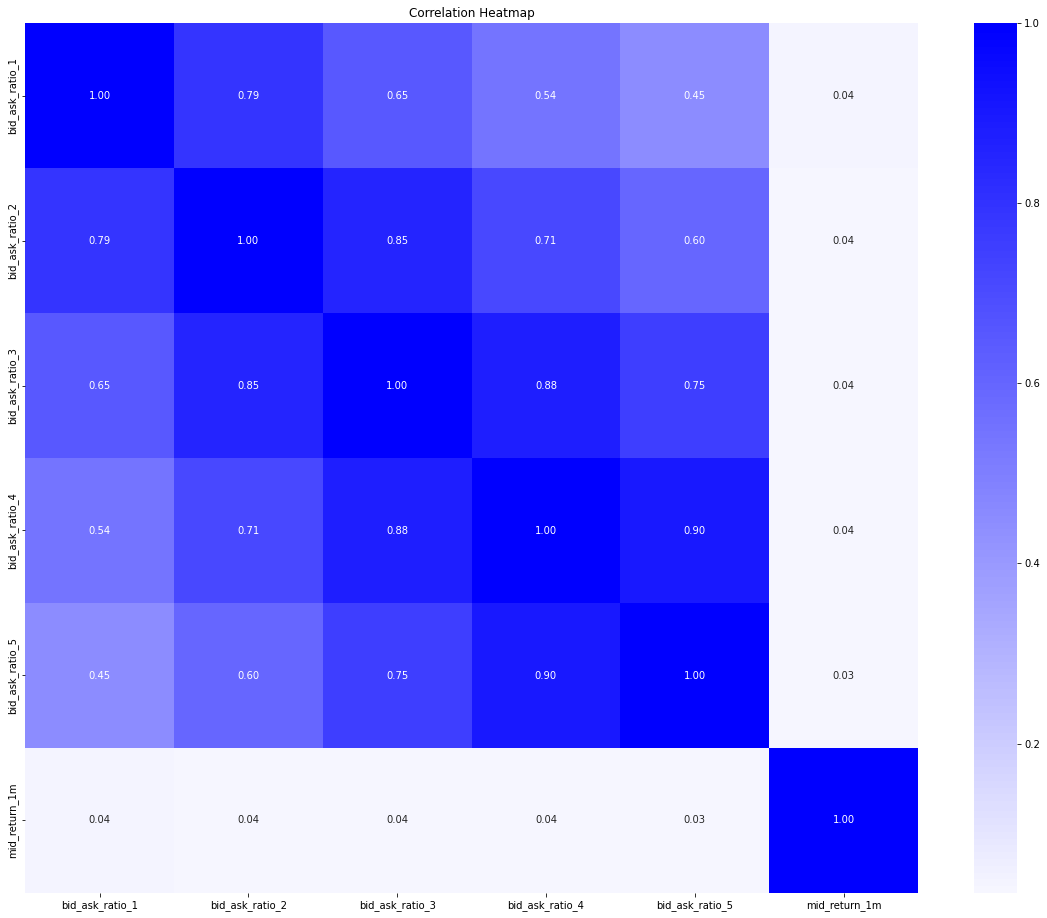

           Feature  Mutual Information
0  bid_ask_ratio_1            0.000000
1  bid_ask_ratio_2            0.009924
2  bid_ask_ratio_3            0.004682
3  bid_ask_ratio_4            0.000796
4  bid_ask_ratio_5            0.000000
bid_ask_ratio_1 0.054302945066050774
bid_ask_ratio_2 0.049804047622275374
bid_ask_ratio_3 0.05090128601535691
bid_ask_ratio_4 0.054794698787082555
bid_ask_ratio_5 0.05140845634195398


In [221]:
xcols = ['bid_ask_ratio_1',
       'bid_ask_ratio_2', 'bid_ask_ratio_3', 'bid_ask_ratio_4',
       'bid_ask_ratio_5',
       ]
show_heat_map(df[xcols + ['mid_return_1m']])
print_mutual_info(df, xcols, 'mid_return_1m')
for col in xcols:
       spearman_corr = df['mid_return_1m'].corr(df[col], method='spearman')
       print(col, spearman_corr)

In [165]:
for i in range(1, 6):
    print(df[trade_df[f'signal_{i}'] == -1.0]['mid_return_1m'].mean() * 10000.0)
    print(df[trade_df[f'signal_{i}'] == 1.0]['mid_return_1m'].mean() * 10000.0)

print(df[trade_df[f'signal_sum'] == -1.0]['mid_return_1m'].mean() * 10000.0)
print(df[trade_df[f'signal_sum'] == 1.0]['mid_return_1m'].mean() * 10000.0)

-3.5151369474233127
-3.698067850798306
-1.562264340773165
8.085036108413142
-0.4149312802957391
2.9632948519338287
0.7117831107904571
2.6568066967821995
-0.7205443477112549
3.0154837847089975
1.6460510606547305
4.014733664737203


In [223]:
df2 = get_yulu_df()

  0%|          | 0/30 [00:00<?, ?it/s]/Users/giovanni/Development/GT Quant/quant_sector/research/notebooks/utils.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/giovanni/Development/GT Quant/quant_sector/research/notebooks/utils.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 30/30 [01:16<00:00,  2.55s/it]


In [228]:
aa = (df2['alpha2'] - df2['alpha2'].rolling(200).mean()) / df2['alpha2'].rolling(200).std()

# bb = (df2['mid_past_return_1m'] - df2['mid_past_return_1m'].rolling(200).mean()) / df2['mid_past_return_1m'].rolling(200).std()
# df2['alpha3'] = aa - bb

In [231]:
df_combined = pd.merge(df, df2[['alpha1', 'alpha2']], left_index=True, right_index=True)
df_combined = df_combined[['bid_ask_ratio_1',
       'bid_ask_ratio_2', 'bid_ask_ratio_3', 'bid_ask_ratio_4',
       'bid_ask_ratio_5', 'alpha1', 'alpha2', 'mid_past_return_1m', 'mid_return_1m']]

In [233]:
aa = (df_combined['alpha2'] - df_combined['alpha2'].rolling(200).mean()) / df_combined['alpha2'].rolling(200).std()

bb = (df_combined['mid_past_return_1m'] - df_combined['mid_past_return_1m'].rolling(200).mean()) / df_combined['mid_past_return_1m'].rolling(200).std()

df_combined['alpha3'] = aa - bb

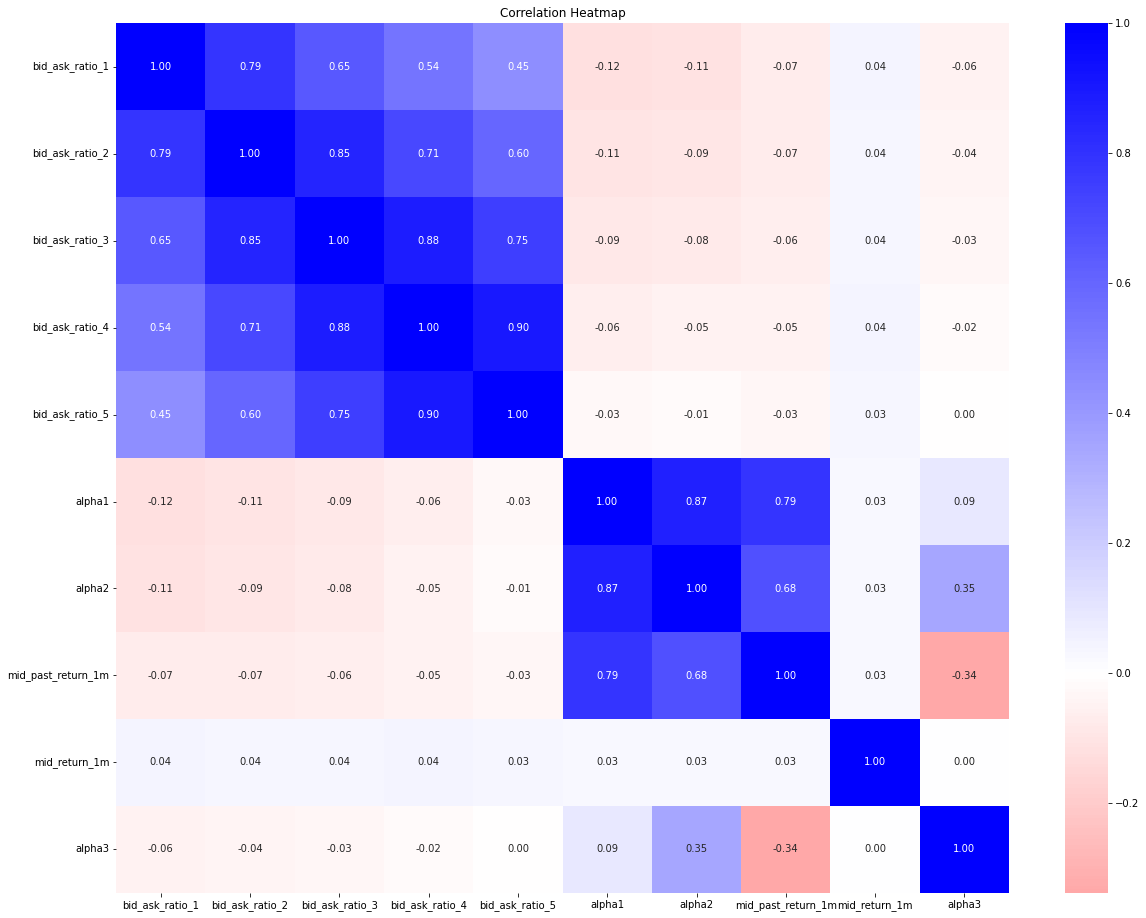

In [234]:
show_heat_map(df_combined)

In [235]:
pnl_df = pd.DataFrame()
pnl_df_d = pd.DataFrame()
ddf = df_combined
ddf['gioooo'] = two_sig_signal_multi(ddf, ['bid_ask_ratio_5', 'alpha2'])

for alpha_col in [f'bid_ask_ratio_{i}' for i in range(1, 6)] + ['alpha1', 'alpha2', 'alpha3', 'gioooo', 'mid_past_return_1m']:
    ddf[f'signal_{alpha_col}'] = two_sig_signal(ddf, alpha_col)
    pnl_df_d[f'pnl_{alpha_col}'] = (ddf[f'signal_{alpha_col}'] * ddf['mid_return_1m'] - ddf[f'signal_{alpha_col}'].abs() * 0.0)
    pnl_df[f'pnl_{alpha_col}'] = pnl_df_d[f'pnl_{alpha_col}'].cumsum()

pnl_df

,pnl_bid_ask_ratio_1,pnl_bid_ask_ratio_2,pnl_bid_ask_ratio_3,pnl_bid_ask_ratio_4,pnl_bid_ask_ratio_5,pnl_alpha1,pnl_alpha2,pnl_alpha3,pnl_gioooo,pnl_mid_past_return_1m
time,,,,,,,,,,
2025-02-13 00:00:00,-0.000000,-0.000000,-0.00000,-0.00000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2025-02-13 00:01:00,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-02-13 00:02:00,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-02-13 00:03:00,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-02-13 00:04:00,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2025-03-14 23:56:00,0.001721,0.034961,0.06309,0.07689,0.177206,0.485964,0.624183,-0.058698,0.480913,0.515096
2025-03-14 23:57:00,0.001721,0.034961,0.06309,0.07689,0.177206,0.485964,0.624183,-0.058698,0.480913,0.515096
2025-03-14 23:58:00,0.001721,0.034961,0.06309,0.07689,0.177858,0.485964,0.624183,-0.058698,0.480913,0.515096


<Axes: xlabel='time'>

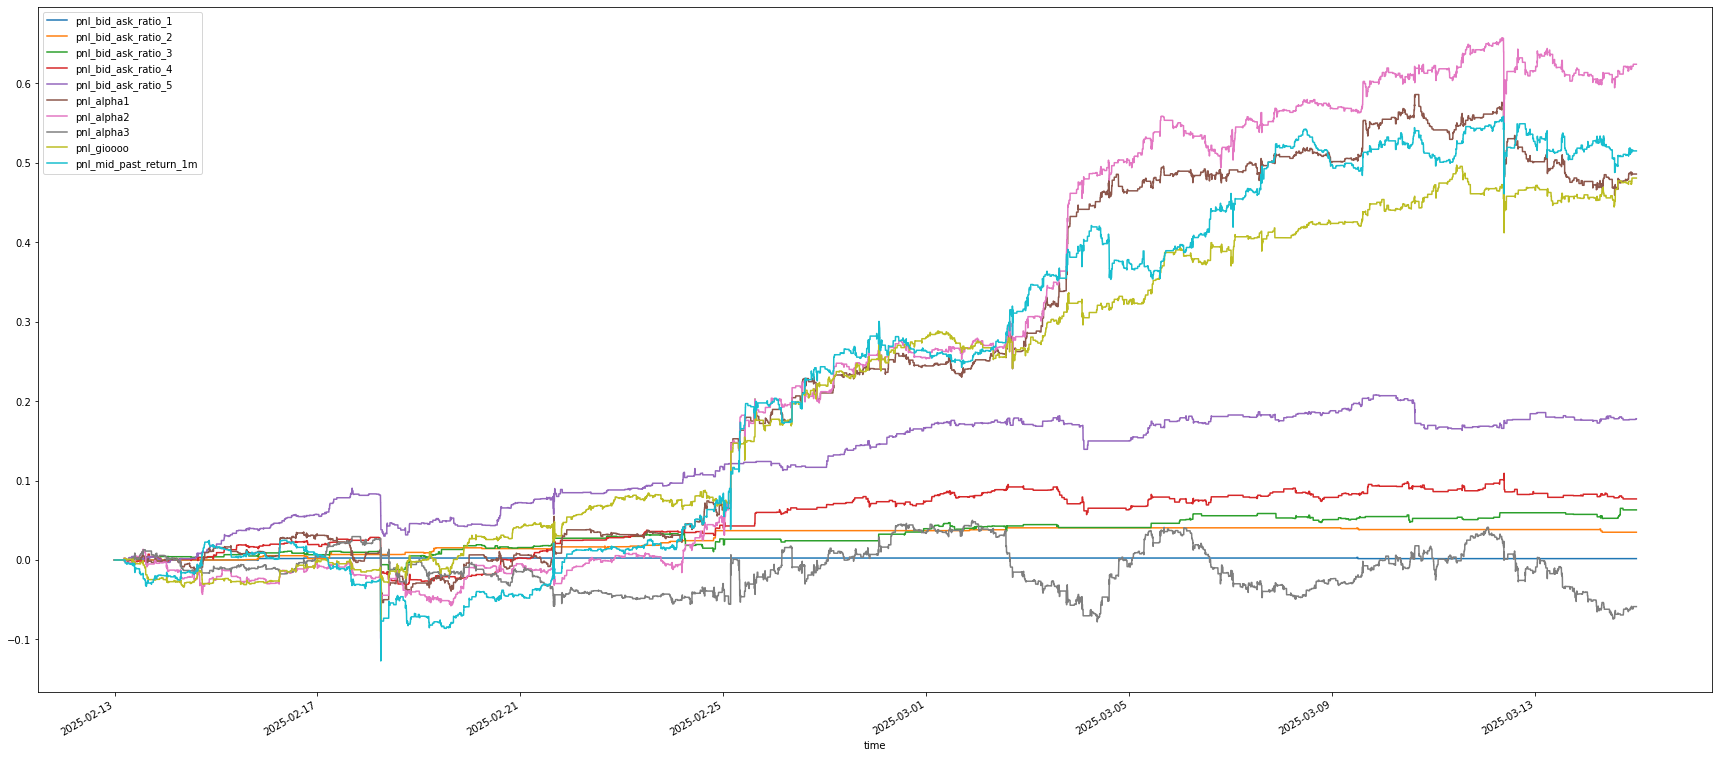

In [236]:
pnl_df.plot(figsize=(30, 14))

In [237]:
for col in pnl_df_d.columns:
    print(f"{col}: {pnl_df_d[col].mean()/pnl_df_d[col].std() * np.sqrt(365 * 1440):.4f}")

pnl_bid_ask_ratio_1: 2.0989
pnl_bid_ask_ratio_2: 8.3418
pnl_bid_ask_ratio_3: 5.2733
pnl_bid_ask_ratio_4: 3.7706
pnl_bid_ask_ratio_5: 7.8766
pnl_alpha1: 9.2322
pnl_alpha2: 10.8837
pnl_alpha3: -1.2303
pnl_gioooo: 10.0736
pnl_mid_past_return_1m: 8.8437


In [156]:
df.index

Index(['2025-02-13 00:00:00', '2025-02-13 00:01:00', '2025-02-13 00:02:00',
       '2025-02-13 00:03:00', '2025-02-13 00:04:00', '2025-02-13 00:05:00',
       '2025-02-13 00:06:00', '2025-02-13 00:07:00', '2025-02-13 00:08:00',
       '2025-02-13 00:09:00',
       ...
       '2025-03-14 23:51:00', '2025-03-14 23:52:00', '2025-03-14 23:53:00',
       '2025-03-14 23:54:00', '2025-03-14 23:55:00', '2025-03-14 23:56:00',
       '2025-03-14 23:57:00', '2025-03-14 23:58:00', '2025-03-14 23:59:00',
       '2025-03-15 00:00:00'],
      dtype='object', name='time', length=43230)

In [154]:
pd.merge(df, df2, left_index=True, right_index=True, how='outer')

,mid_x,bidsize_1,bidsize_2,bidsize_3,bidsize_4,bidsize_5,asksize_1,asksize_2,asksize_3,asksize_4,asksize_5,bidprice_1,bidprice_2,bidprice_3,bidprice_4,bidprice_5,askprice_1,askprice_2,askprice_3,askprice_4,askprice_5,buy_size_x,buy_price_min,buy_price_max,sell_size_x,sell_price_min,sell_price_max,bid_ask_ratio_1,bid_ask_ratio_2,bid_ask_ratio_3,bid_ask_ratio_4,bid_ask_ratio_5,mid_return_1m,bid_adk_ratio_sum,mid_y,mul,buy_size_y,buy_mul,sell_size_y,sell_mul,vwap,alpha1,alpha2
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.8465,NaN,1902.70,49216.10132,6018.98,155684.17131,25.865760,-0.019260,-0.019260
2025-02-13 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.8205,NaN,1118.36,28889.21300,709.46,18329.46363,25.833330,-0.012830,-0.016045
2025-02-13 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.8245,NaN,1286.71,33219.40806,654.15,16886.06062,25.816117,0.008383,-0.003831
2025-02-13 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.7805,NaN,293.54,7570.30155,484.49,12502.14999,25.799071,-0.018571,-0.011201
2025-02-13 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.7255,NaN,475.58,12248.08295,1493.81,38474.29326,25.755374,-0.029874,-0.020538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-14 23:56:00,13.7685,66.49,102.09,168.90,357.46,443.69,201.83,391.69,562.65,918.17,1180.47,13.768,13.766,13.765,13.763,13.762,13.769,13.771,13.772,13.774,13.775,522.18,13.755,13.768,672.65,13.752,13.768,-0.504398,-0.586496,-0.538241,-0.439555,-0.453638,0.000871,-2.522327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-14 23:57:00,13.7805,132.13,155.15,206.10,299.45,373.39,18.67,126.03,183.00,446.46,682.20,13.780,13.778,13.777,13.775,13.774,13.781,13.783,13.784,13.786,13.787,698.14,13.769,13.788,462.82,13.768,13.788,0.752387,0.103564,0.059368,-0.197088,-0.292547,0.001305,0.425683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-14 23:58:00,13.7985,381.76,565.59,692.41,3323.52,15199.22,56.04,83.88,99.14,381.28,453.89,13.798,13.796,13.795,13.793,13.792,13.799,13.801,13.802,13.804,13.805,1719.86,13.781,13.799,651.04,13.786,13.794,0.743993,0.741697,0.749504,0.794170,0.942006,0.000652,3.971370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
df2

,mid,mul,buy_size,buy_mul,sell_size,sell_mul,vwap,alpha1,alpha2
time,,,,,,,,,
2025-02-13 00:00:00,25.8465,NaN,1902.70,49216.10132,6018.98,155684.17131,25.865760,0.019260,0.019260
2025-02-13 00:01:00,25.8205,NaN,1118.36,28889.21300,709.46,18329.46363,25.833330,0.012830,0.016045
2025-02-13 00:02:00,25.8245,NaN,1286.71,33219.40806,654.15,16886.06062,25.816117,-0.008383,0.003831
2025-02-13 00:03:00,25.7805,NaN,293.54,7570.30155,484.49,12502.14999,25.799071,0.018571,0.011201
2025-02-13 00:04:00,25.7255,NaN,475.58,12248.08295,1493.81,38474.29326,25.755374,0.029874,0.020538
...,...,...,...,...,...,...,...,...,...
2025-03-14 23:56:00,13.7685,NaN,522.18,7185.37513,672.65,9253.96884,13.758731,-0.009769,-0.004806
2025-03-14 23:57:00,13.7805,NaN,698.14,9618.94732,462.82,6380.69636,13.781391,0.000891,-0.001957
2025-03-14 23:58:00,13.7985,NaN,1719.86,23720.08861,651.04,8979.00932,13.791850,-0.006650,-0.004304
